In [1]:
import os
import numpy as np
import pandas as pd

split_csv = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/data_split_tang.csv'
label_dir = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'

split_df   = pd.read_csv(split_csv)
test_files = split_df[split_df['split']=='test']['filename'].tolist()

first_lab = np.load(os.path.join(label_dir, test_files[0].replace('.mp3','_labels.npz')))
classes   = list(first_lab.keys())

records = []
for fn in test_files:
    labpath = os.path.join(label_dir, fn.replace('.mp3','_labels.npz'))
    labs_npz = np.load(labpath)
    stats = {}
    total = 0
    num_cls = 0
    for cls in classes:
        votes = (labs_npz[cls].sum(axis=1) >= np.ceil(labs_npz[cls].shape[1]/2))
        cnt = int(votes.sum())
        stats[cls] = cnt
        total += cnt
        if cnt>0:
            num_cls += 1

    T = next(iter(labs_npz.values())).shape[0]
    stats['duration_s'] = round(T * 0.12, 1)
    stats['total_events'] = total
    stats['num_classes']  = num_cls
    stats['filename']     = fn
    records.append(stats)

df = pd.DataFrame(records)

display_cols = ['filename','duration_s','total_events','num_classes'] + classes
df_sorted = df.sort_values('total_events', ascending=False)
df_sorted.head(20)[display_cols]

,filename,duration_s,total_events,num_classes,Airplane,Alarm,Beep/Bleep,Bell,Bicycle,Bird Chirp,...,Stream/River,Thunder,Train,Truck,Trumpet,Vacuum Cleaner,Violin,Washing Machine,Waves,Wind
892,451475.mp3,27.4,1368,6,0,0,0,0,0,0,...,0,0,0,228,0,0,0,0,0,0
211,51173.mp3,23.2,1158,6,0,0,0,0,0,0,...,0,0,0,0,0,193,0,193,0,0
152,27157.mp3,27.5,1145,5,0,0,0,0,0,0,...,0,0,0,229,0,0,0,0,0,0
231,460899.mp3,24.7,1017,6,0,0,0,204,0,0,...,0,0,0,0,0,0,0,0,0,204
853,463254.mp3,23.8,990,5,0,0,0,0,0,0,...,0,0,0,198,0,0,0,0,0,0
311,58939.mp3,23.3,970,5,0,0,0,0,0,0,...,194,0,0,194,0,0,0,0,0,0
158,617125.mp3,28.6,952,4,0,0,0,0,0,0,...,0,0,0,238,0,0,0,0,0,0
536,520852.mp3,19.0,950,8,0,0,0,0,0,0,...,158,0,0,0,132,0,132,0,0,0
902,335437.mp3,22.8,950,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
844,169102.mp3,28.1,936,4,0,0,0,0,0,0,...,0,0,0,234,0,0,0,0,0,0


These are audio files with multiple classes annotated. 

You can try with：

451475.mp3 , 6 classes, see whether model can distigush all classes

27157.mp3, 5 classes, with one train class have 229 frame, this could be a background noise, and see if model can distigush all classes



In [2]:
import os
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

feat_dir   = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
model_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/models'
selected_feats = ['mfcc','embeddings','contrast','flatness', 'bandwidth', 'melspectrogram']

test_files = ['451475.mp3', '27157.mp3']

pipelines = {}
for fn in os.listdir(model_dir):
    if fn.endswith('.joblib'):
        cls_name = fn.replace('svm_','').replace('.joblib','').replace('_',' ')
        pipelines[cls_name] = joblib.load(os.path.join(model_dir, fn))

for fn in test_files:
    print(f"\n=== Predictions for {fn} ===")

    arr = np.load(os.path.join(feat_dir, fn.replace('.mp3', '.npz')))
    X = np.concatenate([arr[f] for f in selected_feats], axis=1)
    
    preds = {}
    for cls, pipe in tqdm(pipelines.items(), desc=f"Predicting {fn}", leave=False):
        preds[cls] = pipe.predict(X)

    df = pd.DataFrame(preds)
    df['time_s'] = np.arange(len(df)) * 0.12 

    counts = df.drop(columns='time_s').sum().sort_values(ascending=False)
    print("Positive frame counts per class:")
    print(counts[counts > 0])

    out_csv = fn.replace('.mp3', '_predictions.csv')
    df.to_csv(out_csv, index=False)
    print(f"Saved predictions to {out_csv}")


=== Predictions for 451475.mp3 ===


Positive frame counts per class:
Hammer        104
Horn Honk      52
Jackhammer     34
Car            33
Speech          3
dtype: int64
Saved predictions to 451475_predictions.csv

=== Predictions for 27157.mp3 ===


Positive frame counts per class:
Speech    202
dtype: int64
Saved predictions to 27157_predictions.csv


well， not very good when working with background noise

you can hear the files and find out more

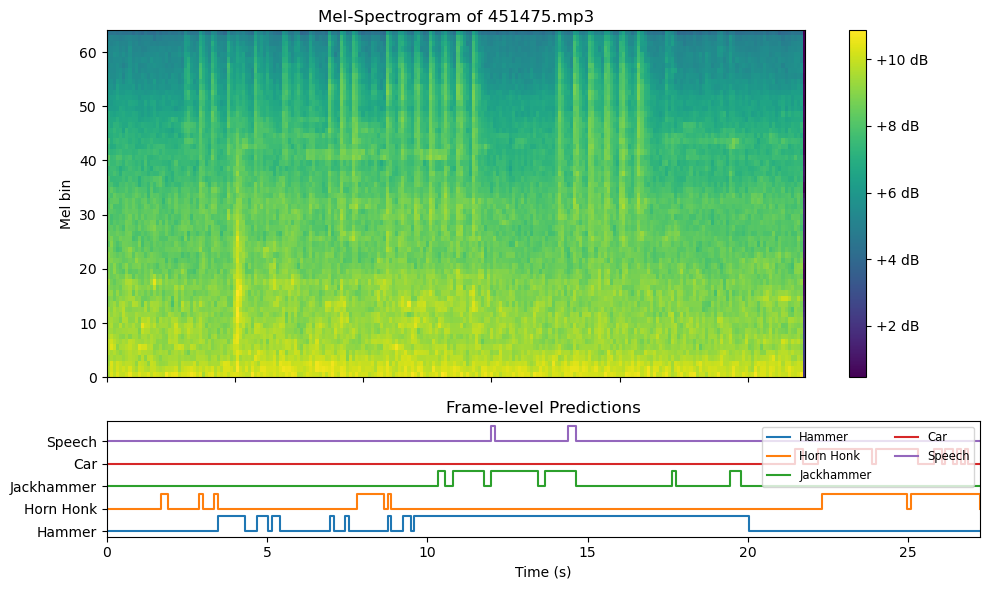

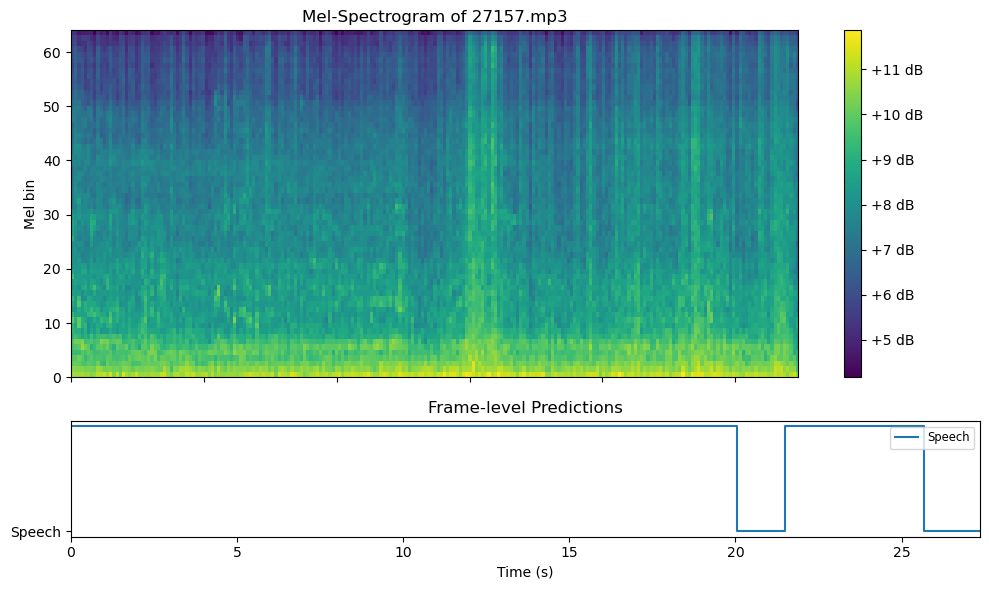

In [ ]:
import matplotlib.pyplot as plt

feat_dir   = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
pred_dir   = '.'  
selected_classes = None 

test_files = ['451475.mp3', '27157.mp3']

for fn in test_files:
    base = fn.replace('.mp3','')

    feats = np.load(os.path.join(feat_dir, base + '.npz'))
    melspec = feats['melspectrogram']    # shape (T, 64)
    T, n_mel = melspec.shape

    times = np.arange(T) * 0.12

    dfp = pd.read_csv(base + '_predictions.csv') 
    dfp = dfp.set_index('time_s')  

    if selected_classes is None:
        counts = dfp.drop(columns=[]).sum().sort_values(ascending=False)
        selected = list(counts[counts>0].index[:5])
    else:
        selected = selected_classes

    fig, (ax_spec, ax_pre) = plt.subplots(2, 1, figsize=(10, 6),
                                          sharex=True,
                                          gridspec_kw={'height_ratios':[3,1]})

    im = ax_spec.imshow(
        melspec.T,
        origin='lower',
        aspect='auto',
        extent=[0, times[-1], 0, n_mel]
    )
    ax_spec.set_ylabel('Mel bin')
    ax_spec.set_title(f'Mel-Spectrogram of {fn}')
    fig.colorbar(im, ax=ax_spec, format='%+2.0f dB')

    for i, cls in enumerate(selected):
        y = dfp[cls].values.astype(int)
        ax_pre.step(times, y + i*1.5, where='post', label=cls)
    ax_pre.set_yticks([i*1.5 for i in range(len(selected))])
    ax_pre.set_yticklabels(selected)
    ax_pre.set_xlabel('Time (s)')
    ax_pre.set_title('Frame-level Predictions')
    ax_pre.legend(loc='upper right', ncol=2, fontsize='small')

    plt.tight_layout()
    plt.show()
